In [3]:
import nashpy as nash
import numpy as np
from scipy.special import softmax
from scipy.stats import entropy
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

from simu import *

import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def seob_strategy_per_it(u, p_init, marginal='exponential', params=None, step_size=0.01):
    """
    Compute the SE-OB strategy for a given utility vector u.
    
    Args:
        u: 1D array of expected payoffs (shape: [K])
        marginal: 'exponential', 'uniform', or 'tsallis'
        params: dict of parameters, e.g., {'eta': ..., 'gamma': ..., 'q': ...}
        
    Returns:
        p: SE-OB strategy (array of shape [K])
    """

    def proj_simplex(x):
        sorted_x = np.sort(x)[::-1]
        cumsum = np.cumsum(sorted_x)
        rho = np.where(sorted_x > (cumsum - 1) / (np.arange(K) + 1))[0][-1]
        theta = (cumsum[rho] - 1) / (rho + 1)
        return np.maximum(x - theta, 0)

    u = np.array(u)
    K = len(u)
    
    if params is None:
        params = {}

    if marginal == 'exponential':
        # τ_i ∝ η_i * exp(u_i / γ)
        eta = params.get('eta', np.ones(K))
        gamma = params.get('gamma', 1.0)
        logits = eta * np.exp(u / gamma)
        p = logits / logits.sum()

    elif marginal == 'uniform':
        # τ = sparsemax(u / γ)
        gamma = params.get('gamma', 1.0)
        v = (u / gamma + 1)/(2*K)
        p = sparsemax(v)


    elif marginal == 'tsallis':
        # Solve: max_{p in simplex} <p, u> - γ/(q-1) * sum_i η_i [(p_i/η_i)^q - (p_i/η_i)]
        eta = params.get('eta', np.ones(K))
        gamma = 2.0 * params.get('gamma', 1.0)
        q = params.get('q', 2.0)

        # Closed-form solution doesn't exist; use projected gradient ascent
        def objective(p):
            term1 = np.dot(p, u)
            term2 = - gamma * (1/(q - 1)) * np.sum(eta * ((p / eta) ** q - (p / eta)))
            return term1 + term2
        
        def grad(p):
            return u - gamma * q * ((p / eta) ** (q - 1)) / (q - 1) + gamma / (q - 1)


        p = p_init.copy() if p_init is not None else np.ones(K) / K
        for _ in range(1):
            p += step_size * grad(p)
            p = proj_simplex(p)

    else:
        raise ValueError(f"Unknown marginal: {marginal}")
    
    return p


def compute_seob_equilibrium(U1, U2, marginal, params, step_size=0.001, max_iter=100, tol=1e-6):
    N = U1.shape[0]
    # Initialize both players with uniform strategy
    p1 = np.ones(N) / N
    p2 = np.ones(N) / N

    for iteration in range(max_iter):
        u1 = expected_payoff(U1, p2, axis=1)
        new_p1 = seob_strategy(u1, marginal, params, step_size)

        u2 = expected_payoff(U2.T, p1, axis=0)
        new_p2 = seob_strategy(u2, marginal, params, step_size)

        delta = np.linalg.norm(new_p1 - p1) + np.linalg.norm(new_p2 - p2)
        p1, p2 = new_p1, new_p2

        if delta < tol:
            break

    return p1, p2

In [5]:
def simu(U1, U2, params, step_size=0.001):
    N = U1.shape[0]

    tau = params.get('gamma', 1.0)
    p, q = qre_fixed_point(U1, U2, tau)
    qre = list([p, q])

    marginal = 'uniform'
    p1_star, p2_star = compute_seob_equilibrium(U1, U2, marginal, params, step_size)
    p1_star, p2_star = np.round(p1_star, 3), np.round(p2_star, 3)
    seob_unif = list([p1_star, p2_star])


    marginal = 'exponential'
    p1_star, p2_star = compute_seob_equilibrium(U1, U2, marginal, params, step_size)
    p1_star, p2_star = np.round(p1_star, 3), np.round(p2_star, 3)
    seob_exp = list([p1_star, p2_star])


    marginal = 'tsallis'
    p1_star, p2_star = compute_seob_equilibrium(U1, U2, marginal, params, step_size)
    p1_star, p2_star = np.round(p1_star, 3), np.round(p2_star, 3)
    seob_tsallis = list([p1_star, p2_star])

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    bar_width = 0.35
    # Plot histograms
    actions_p1 = np.arange(N)
    actions_p2 = np.arange(N)

    ax[0].bar(actions_p1 - bar_width/2, qre[0], bar_width, label='row player')
    ax[0].bar(actions_p2 + bar_width/2, qre[1], bar_width, label='column player')
    ax[0].set_xticks(actions_p1)
    ax[0].set_xticklabels([f"A{i+1}" for i in actions_p1])
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel("Probability")
    ax[0].set_title(f"logit-QRE Strategies")
    ax[0].legend()


    ax[1].bar(actions_p1 - bar_width/2, seob_unif[0], bar_width, label='row player')
    ax[1].bar(actions_p2 + bar_width/2, seob_unif[1], bar_width, label='column player')
    ax[1].set_xticks(actions_p1)
    ax[1].set_xticklabels([f"A{i+1}" for i in actions_p1])
    ax[1].set_ylim(0, 1)
    ax[1].set_ylabel("Probability")
    ax[1].set_title(f"sparsemax-SE-OB Strategies")
    ax[1].legend()

    ax[2].bar(actions_p1 - bar_width/2, seob_tsallis[0], bar_width, label='row player')
    ax[2].bar(actions_p2 + bar_width/2, seob_tsallis[1], bar_width, label='column player')
    ax[2].set_xticks(actions_p1)
    ax[2].set_xticklabels([f"A{i+1}" for i in actions_p1])
    ax[2].set_ylim(0, 1)
    ax[2].set_ylabel("Probability")
    ax[2].set_title(f"Tsallis-SE-OB Strategies")
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    return qre, seob_exp, seob_unif, seob_tsallis

def random_simplex_vector(K):
    x = np.random.rand(K)
    return x / x.sum()

In [6]:
params = {'eta': 1.0 * np.ones(2), 'gamma': 20.0, 'q': 1.5}

Nash Equilibrium strategies: (array([0.16666667, 0.83333333]), array([0.5, 0.5]))


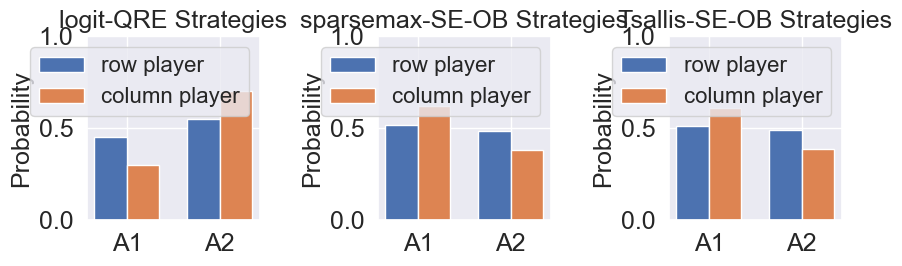

Nash Equilibrium strategies: (array([0.16666667, 0.83333333]), array([0.5, 0.5]))


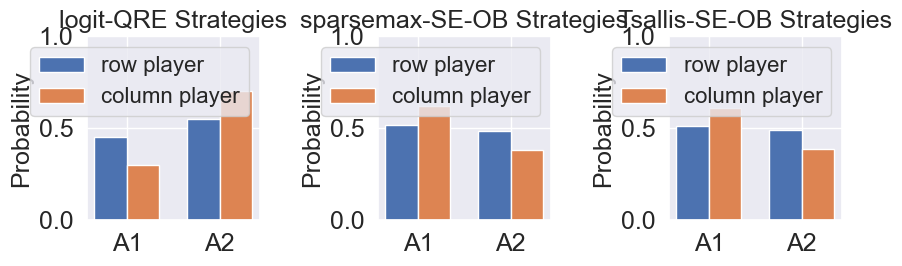

Nash Equilibrium strategies: (array([0.16666667, 0.83333333]), array([0.5, 0.5]))


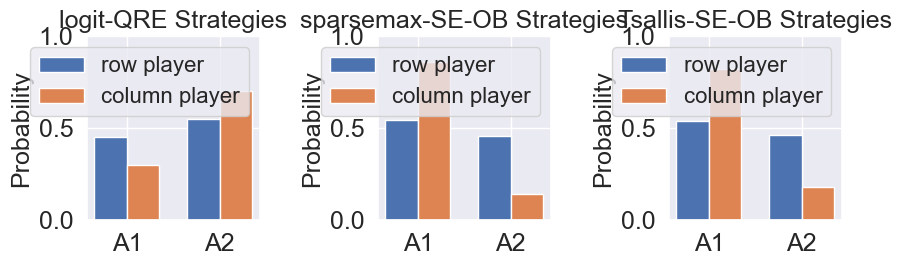

Nash Equilibrium strategies: (array([0.16666667, 0.83333333]), array([0.5, 0.5]))


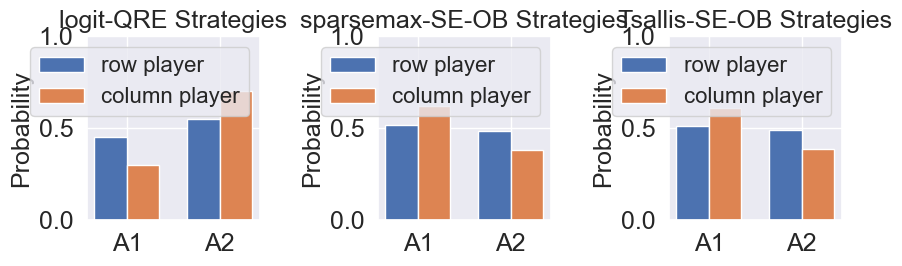

Nash Equilibrium strategies: (array([0.16666667, 0.83333333]), array([0.5, 0.5]))


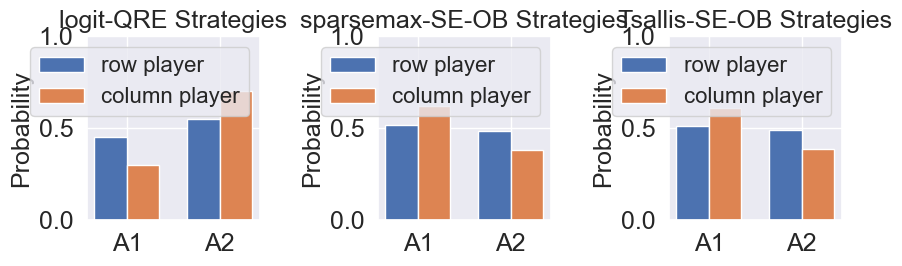

[[0.45002218 0.515      0.513     ]
 [0.45002218 0.515      0.513     ]
 [0.45002218 0.545      0.538     ]
 [0.45002218 0.515      0.513     ]
 [0.45002218 0.515      0.513     ]]
[[0.2994189 0.619     0.612    ]
 [0.2994189 0.619     0.612    ]
 [0.2994189 0.858     0.82     ]
 [0.2994189 0.619     0.612    ]
 [0.2994189 0.619     0.612    ]]


In [7]:
X_seq = [10, 50, 50, 50, 50]
Y_seq = [10, 10, 10, 50, 50]
Z_seq = [10, 10, 50, 50, 50]
W_seq = [10, 10, 10, 10, 50]

p1_seq = []
q1_seq = []

for i in range(5):
    X, Y, Z, W = X_seq[i], Y_seq[i], Z_seq[i], W_seq[i]
    U1 = np.array([
        [X+10, W],
        [X, W+10]
    ])
    U2 = np.array([
        [Z, Z+50],
        [Y+10, Y]
    ])

    N = U1.shape[0]

    # Nash equilibrium
    game = nash.Game(U1, U2)
    equilibria = list(game.support_enumeration())
    for eq in equilibria:
        print(f"Nash Equilibrium strategies: {eq}")

    # SE-OB
    qre, seob_exp, seob_unif, seob_tsallis = simu(U1, U2, params)
    
    p1_seq.append(np.array([qre[0][0], seob_unif[0][0], seob_tsallis[0][0]]))
    q1_seq.append(np.array([qre[1][0], seob_unif[1][0], seob_tsallis[1][0]]))

p1_seq = np.array(p1_seq)
q1_seq = np.array(q1_seq)

print(p1_seq)
print(q1_seq)

[0, 0]
[0, 1]
[0, 2]
[1, 0]
[1, 1]


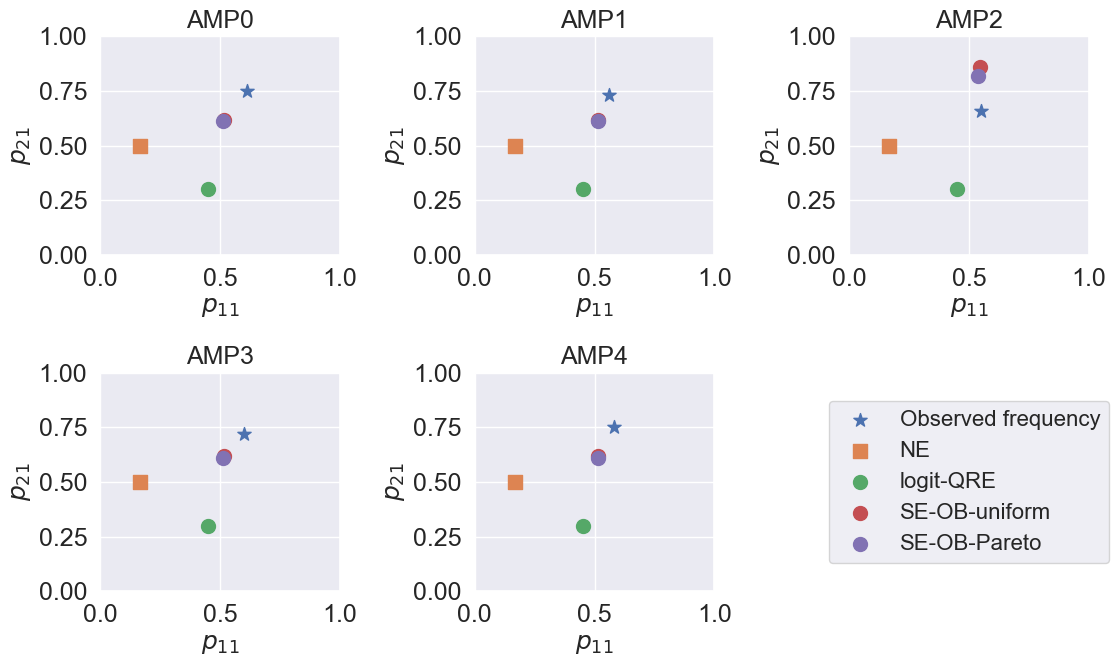

In [8]:
freq1_seq = [
    np.array([0.61, 0.39]),
    np.array([0.56, 0.44]),
    np.array([0.55, 0.45]),
    np.array([0.60, 0.40]),
    np.array([0.58, 0.42])
]

freq2_seq = [
    np.array([0.75, 0.25]),
    np.array([0.73, 0.27]),
    np.array([0.66, 0.34]),
    np.array([0.72, 0.28]),
    np.array([0.75, 0.25])
]

fig, ax = plt.subplots(2, 3, figsize=(11.5, 7))
p1_NE = equilibria[0][0]
q1_NE = equilibria[0][1]
for i in range(5):
    ii = i // 3
    j = i - ii * 3
    print([ii,j])
    ax[ii][j].set_xlim((0,1))
    ax[ii][j].set_ylim((0,1))
    ax[ii][j].set_xlabel(r'$p_{11}$')
    ax[ii][j].set_ylabel(r'$p_{21}$')
    ax[ii][j].scatter(freq1_seq[i][0], freq2_seq[i][0], label='Observed frequency', marker='*', s=100)
    ax[ii][j].scatter(p1_NE[0], q1_NE[0], label='NE', marker='s', s=100)
    ax[ii][j].scatter(p1_seq[i][0], q1_seq[i][0], label='logit-QRE', s=100)
    ax[ii][j].scatter(p1_seq[i][1], q1_seq[i][1], label='SE-OB-uniform', s=100)
    ax[ii][j].scatter(p1_seq[i][2], q1_seq[i][2], label='SE-OB-Pareto', s=100)
    ax[ii][j].set_title(f"AMP{i}")
ax[1][2].axis('off') 

handles, labels = ax[0][0].get_legend_handles_labels()
ax[1][2].legend(handles, labels, loc='center')

plt.tight_layout()
plot_dir = './AMP.pdf'
plt.savefig(plot_dir, bbox_inches='tight')